# Movie Database Part 7

*Christina Brockway*

**Part 1:  Preparing Best Models for Streamlit**
1.  Filepaths
    -  Define filepaths dictionary
    -  Save to config/filepaths.json
    -  include file paths for each component to save
2.  Copy best models
    - choose models from part 6
    - copy in to nb
    - update code to define public-facing class labels
3.  For Machine Learning
    -  save training data
    -  save testing data
    -  save target_lookup dictionary and/or label encoder
    -  save best model
4.  For Deep NLP model
    -  save training data
    -  save testing data
    -  save best neural network
    -  use safe_format='tf'

**Part 2: Streamlit App**
Create a Streamlit app to get model predictions for user entered-text
1.  Select model to use (ML or deep NLP)
2.  get predictions
3.  user-entered text
4.  include LimeTextExplainer explanation for prediction
5.  include abiblity to load evalution

In [1]:
## Define a file path

from pprint import pprint
FPATHS = dict(
        data={
        "filtered":  "data/movie-reviews-filtered.csv",
        "processed": "data/movie-reviews-tokenized.joblib",
        "ml": {
            "train": "data/training-data.joblib",  
            "test": "data/testing-data.joblib",
            
            "label_encoder":"data/label-encoder.joblib",
            'target_lookup':"data/target-lookup-dict.joblib",
            
        },
        "tf": {
            "train_tf": "data/training_tf",  
            "test_tf": "data/testing_tf", 
         },           
    },
    models={
        "rf": "models/rf-pipe.joblib", 
        "gscv": "models/best_model.joblib", 
        "gru": "models/tf/"
    },
    eda = {
        "scattertext": "eda/scattertext.html",
        "wordclouds-raw": "eda/wordclouds-raw-text.png",
        'wordclouds-lemmas':"eda/wordclouds-lemmas.png",
    }
)
pprint(FPATHS)

{'data': {'filtered': 'data/movie-reviews-filtered.csv',
          'ml': {'label_encoder': 'data/label-encoder.joblib',
                 'target_lookup': 'data/target-lookup-dict.joblib',
                 'test': 'data/testing-data.joblib',
                 'train': 'data/training-data.joblib'},
          'processed': 'data/movie-reviews-tokenized.joblib',
          'tf': {'test_tf': 'data/testing_tf', 'train_tf': 'data/training_tf'}},
 'eda': {'scattertext': 'eda/scattertext.html',
         'wordclouds-lemmas': 'eda/wordclouds-lemmas.png',
         'wordclouds-raw': 'eda/wordclouds-raw-text.png'},
 'models': {'gru': 'models/tf/',
            'gscv': 'models/best_model.joblib',
            'rf': 'models/rf-pipe.joblib'}}


In [2]:
#Save  filepaths in a config folder

import os, json
os.makedirs('config/', exist_ok = True)
FPATHS_FILE = 'config/filepaths.json'
with open(FPATHS_FILE, 'w') as f:
    json.dump(FPATHS, f)

In [3]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
import spacy
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)


In [4]:
import os, sys
%load_ext autoreload
%autoreload 2
import stdfunctions as sf

In [5]:
# Check sys.path for python path
sys.path
#Get the absolute file path of parent directory
os.path.abspath('../')
#Add parent directory to python path
sys.path.append( os.path.abspath('../'))

In [6]:
# Using function from Creating a File Structure Lesson
sf.create_directories_from_paths(FPATHS)

In [7]:
processed = joblib.load("data/processed_data.joblib")

In [8]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2422 entries, 1 to 8647
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   review         2422 non-null   object 
 1   rating         2422 non-null   float64
 2   html           160 non-null    object 
 3   length         2422 non-null   int64  
 4   tokens         2422 non-null   object 
 5   lemmas         2422 non-null   object 
 6   tokens-joined  2422 non-null   object 
 7   lemmas-joined  2422 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 170.3+ KB


In [9]:
len(processed)

2422

In [10]:
#drop reviews without a rating and irrelevent columns
#There are no rows without ratings
processed=processed.drop(columns=(['html', 'length','tokens','lemmas','tokens-joined','lemmas-joined']))
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2422 entries, 1 to 8647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  2422 non-null   object 
 1   rating  2422 non-null   float64
dtypes: float64(1), object(1)
memory usage: 56.8+ KB


In [11]:
#Split into high and low reviews
df = processed.copy()
def rating_groups(x):
    if x>=8.5:
        return "high"
    elif x <=4.0:
        return "low"
    else: 
        return None

In [25]:
df['label'] = processed['rating'].map(rating_groups)

# Map numeric value with public-facing label
rename_target_map ={'low': 'Low Rating', 'high':'High Rating'}

# Replace y values
y = df['label'].replace(rename_target_map)
# Define X as normal
X = df['review']

df['label'].value_counts()

low     1223
high    1199
Name: label, dtype: int64

In [26]:
df.head(2)

,review,label
1,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy anima...",high
6,"the first underwhelmed me, but this one straight-up bored me. again, of course seeing hunt climb a mountain without a harness is impressive sure. and i even quite liked the idea behind the villain of the piece (though even that angle was woefully...",low


In [28]:
#df=df.drop(columns=('rating'))

In [29]:
# Train test split
X_train, X_test, y_train_str, y_test_str = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)

In [30]:
### Encoding Labels
## 1.  obtain class names

# Getting unique classes to convert 
class_names = y_train_str.unique()
class_names


array(['Low Rating', 'High Rating'], dtype=object)

In [31]:
## 2. instantiate and fit LabelEncoder

from sklearn.preprocessing import LabelEncoder
# Fit the label encoder on unique class names
encoder = LabelEncoder()
encoder.fit(class_names)

LabelEncoder()

In [32]:
### 3.  Transform string values with encoder

# Transform the y_train_str and y_test_str with encoder
y_train = encoder.transform(y_train_str)
y_test = encoder.transform(y_test_str)
y_train[:10]

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1])

In [37]:
#### 4.  Extract class names from the encoder object

# Extract the class names from the encoder
classes = encoder.classes_
classes

array(['High Rating', 'Low Rating'], dtype=object)

In [38]:
##### 5. Transform these to obtain the encoded values

# Get the encoded values for both classes
class_codes = encoder.transform(classes)
class_codes

array([0, 1])

In [39]:
###### 6. Make lookup dictionary that will match the ncoded value with the string name

# Making lookup dictionary to find the encoded label's original name
target_lookup = dict(zip(class_codes,classes ))
target_lookup

{0: 'High Rating', 1: 'Low Rating'}

In [40]:
### Class Balance

# Check for class balance
pd.Series(y_train).value_counts(normalize=True)

1    0.504405
0    0.495595
dtype: float64

In [41]:
# Use RUS to balance the classes
sampler = RandomUnderSampler(random_state=42)
X_train, y_train = sampler.fit_resample(X_train.values.reshape(-1,1),y_train)
X_train = X_train.flatten()

# Check for class balance
pd.Series(y_train).value_counts(normalize=True)

0    0.5
1    0.5
dtype: float64

In [42]:
#Save filtered dataframe
fpath = FPATHS['data']['filtered']
df.to_csv(fpath)

#Saving the training data
fpath_train  = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train], fpath_train)

# Saving the testing data
fpath_test = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test], fpath_test)

#Save encoder
fpath_encoder = FPATHS['data']['ml']['label_encoder']
joblib.dump(encoder,fpath_encoder)

# Save dictionary
fpath_lookup = FPATHS['data']['ml']['target_lookup']
joblib.dump(target_lookup,fpath_lookup )

['data/target-lookup-dict.joblib']

### Machine Learning Model

In [44]:
#Create pipeline

# Select a sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words ='english')

#Use RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

rfc_pipe = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', rfc)])


In [45]:
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       1.00      1.00      1.00       900

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



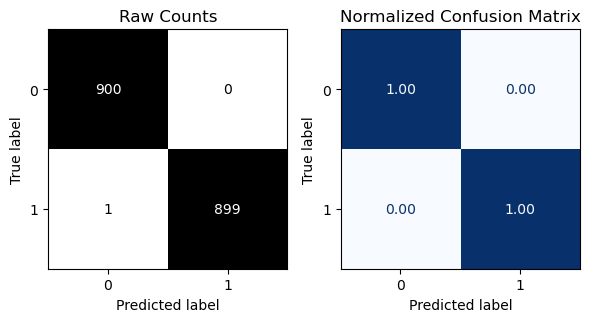


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       299
           1       0.89      0.79      0.83       307

    accuracy                           0.84       606
   macro avg       0.85      0.84      0.84       606
weighted avg       0.85      0.84      0.84       606



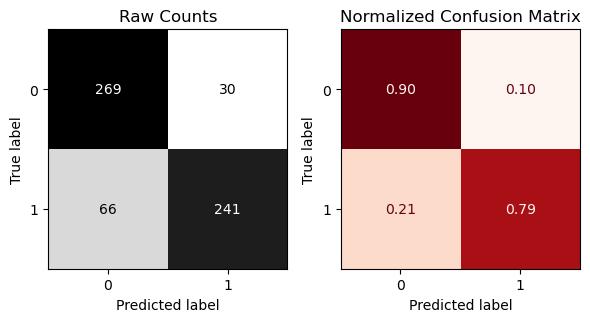

In [46]:
sf.evaluate_classification(rfc_pipe, X_train, y_train, X_test, y_test)

In [80]:
#Save random forest model pipeline

fpath_rf_pipe = FPATHS['models']['rf']
joblib.dump(rfc_pipe, fpath_rf_pipe)

['models/rf-pipe.joblib']

#### Deep NLP

In [48]:
# load training data using dictionary
[X_train, y_train] = joblib.load(FPATHS['data']['ml']['train'])
[X_test, y_test]  = joblib.load(FPATHS['data']['ml']['test'])
X_train[:5],y_train[:5]

(array(["you measure yourself by the people who measure themselves by you.\r\n\r\njack nicholson and morgan freeman play two terminally ill men who check out of their cancer ward and head off on a road trip to complete their bucket list of things to do before they die.\r\n\r\nevery once in a while a film comes along with such simplicity of warmth it rises above any charge of clichés and sugar coated sappiness. the bucket list is one such film. its message is simple, its filming style equally so. it's performed with such quality by nicholson and freeman (if the whole film had just been the two of them chatting in the hospital room it would have been a winner), with director rob reiner astute and wily enough to let them flow, that even as the inevitable sadness follows the laughs, you will feel far better for having watched this film.\r\n\r\nrewarding adult cinema with class showing on both sides of the camera. 8.5/10",
        'click here for a video version of this review: https://yout

### Prepare Dataset for TensorFlow

In [49]:
# Make a dataset object from train data
train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Make a dataset object from test data
test_tf = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [50]:
# Shuffle dataset
train_tf = train_tf.shuffle(buffer_size=len(train_tf),reshuffle_each_iteration=False)

In [51]:
len(train_tf), len(test_tf)

(1800, 606)

In [52]:
# Set the ratio of the train, validation, test split
split_train = .75
split_val =  .25
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(train_tf) * split_train)
n_val_samples = int(len(train_tf) * split_val)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")


    - train:	1350 samples 	(43 batches)
    - val:  	450 samples 	(15 batches)


In [53]:
# Use take and skip to define each set
train_ds = train_tf.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = train_tf.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')

 There are 43 training batches.
 There are 15 validation batches.


In [54]:
# How many samples in the test data
n_test_samples = len(test_tf)
n_test_samples

606

In [55]:
# Put the test data into batches also
test_ds = test_tf.batch(batch_size = BATCH_SIZE)
# How many batches
print (f' There are {len(test_ds)} testing batches.')

 There are 19 testing batches.


In [56]:
# Save training dataset object
train_ds_fpath = FPATHS['data']['tf']['train_tf']
tf.data.Dataset.save(train_ds, train_ds_fpath)
# Save testing dataset object
test_ds_fpath = FPATHS['data']['tf']['test_tf']
tf.data.Dataset.save(test_ds, test_ds_fpath)

In [57]:
##Obtain a single batch from training data to sample

# Define classes
# classes = np.unique(example_y)
encoder = joblib.load(FPATHS['data']['ml']['label_encoder'])
classes = encoder.classes_
classes

array(['High Rating', 'Low Rating'], dtype=object)

In [58]:
# Create Text Vectorization Layer
sequence_vectorizer, vocab_lookup = sf.make_text_vectorization_layer(
    train_ds, output_mode="int", output_sequence_length=30, verbose=True
)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 30,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 22298}
)


In [59]:
sequence_vectorizer.vocabulary_size()

22298

In [60]:
from keras import regularizers

def build_gru_bidirectional_pool(text_vectorization_layer):
    
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()                
    
    rnn_model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                        output_dim=EMBED_DIM,  input_length=SEQUENCE_LENGTH)])
   
# Stack three GrU layers    
    rnn_model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True, 
                                  kernel_regularizer=regularizers.l2(0.0001))))
    rnn_model.add(layers.Dropout(0.3))
    rnn_model.add(layers.GRU(64, return_sequences=True,
                             kernel_regularizer=regularizers.l1(0.0001)))
    rnn_model.add(layers.Dropout(0.2))
    rnn_model.add(layers.GRU(32, return_sequences=True,
                             kernel_regularizer=regularizers.l2(0.0001)))
          
    rnn_model.add(layers.Bidirectional(layers.GRU(32, return_sequences = True,)))
                  
    # Add a pooling layer 
    rnn_model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    rnn_model.add(layers.Dense(len(classes), 
                                    activation='sigmoid'))
                     
    optimizer = optimizers.legacy.Adam()
    rnn_model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    rnn_model.summary()
    return rnn_model

In [61]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy', min_delta=1e-2,):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [62]:
# Build the model
EMBED_DIM = 100
SEQUENCE_LENGTH = 150
model = build_gru_bidirectional_pool(sequence_vectorizer)

#Fit the model
EPOCHS = 20
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 100)           2229800   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          176640    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 gru_1 (GRU)                 (None, 30, 64)            61824     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0

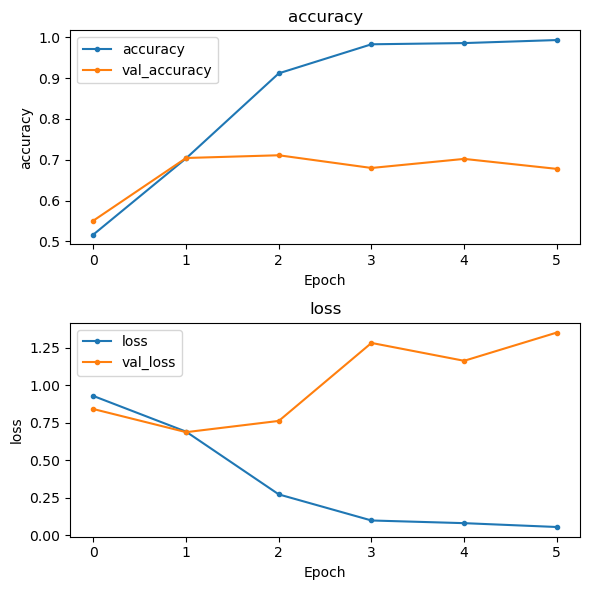


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       686
           1       0.97      0.98      0.98       664

    accuracy                           0.98      1350
   macro avg       0.98      0.98      0.98      1350
weighted avg       0.98      0.98      0.98      1350



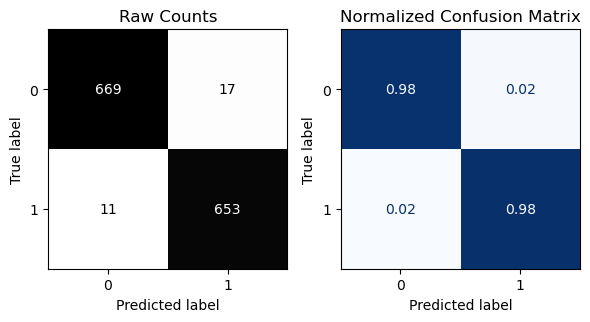


- Evaluating Training Data:
43/43 [==============================] - 1s 21ms/step - loss: 0.0877 - accuracy: 0.9793
{'loss': 0.08772306889295578, 'accuracy': 0.9792592525482178}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       299
           1       0.75      0.61      0.67       307

    accuracy                           0.70       606
   macro avg       0.70      0.70      0.69       606
weighted avg       0.70      0.70      0.69       606



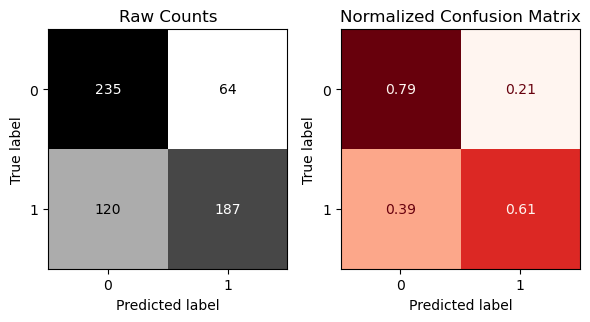


- Evaluating Test Data:
19/19 [==============================] - 0s 22ms/step - loss: 1.2935 - accuracy: 0.6964
{'loss': 1.293513536453247, 'accuracy': 0.6963696479797363}


In [63]:
# Obtain the results
results = sf.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);
results

In [83]:
### Save deep NLP model 

fpath_nlp = FPATHS['models']['gru']
joblib.dump(model, fpath_nlp)

PermissionError: [Errno 13] Permission denied: 'models/tf/'

In [67]:
def load_Xy_data(fpath):
   return joblib.load(fpath)

In [68]:
# Call function for train data
X_train, y_train = load_Xy_data(fpath=FPATHS['data']['ml']['train'])
# Call function for test data
X_test, y_test = load_Xy_data(fpath=FPATHS['data']['ml']['test'])



In [69]:
# Define function to load in model from dictionary with joblib
def load_ml_model(fpath):
   return joblib.load(fpath)

In [70]:
FPATHS


{'data': {'filtered': 'data/movie-reviews-filtered.csv',
  'processed': 'data/movie-reviews-tokenized.joblib',
  'ml': {'train': 'data/training-data.joblib',
   'test': 'data/testing-data.joblib',
   'label_encoder': 'data/label-encoder.joblib',
   'target_lookup': 'data/target-lookup-dict.joblib'},
  'tf': {'train_tf': 'data/training_tf', 'test_tf': 'data/testing_tf'}},
 'models': {'rf': 'models/rf-pipe.joblib',
  'gscv': 'models/best_model.joblib',
  'gru': 'models/tf/'},
 'eda': {'scattertext': 'eda/scattertext.html',
  'wordclouds-raw': 'eda/wordclouds-raw-text.png',
  'wordclouds-lemmas': 'eda/wordclouds-lemmas.png'}}

In [71]:

## Loading the ML model
#@st.cache_resource
def load_ml_model(fpath):
    loaded_model = joblib.load(fpath)
    return loaded_model



In [77]:
joblib.load(FPATHS['models']['rf'])

EOFError: 

In [74]:
model=


'models/rf-pipe.joblib'

In [75]:
clf_pipe = load_ml_model(model)

TypeError: expected str, bytes or os.PathLike object, not Sequential